In [1]:
import pandas as pd
import numpy as np 
import keras
from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
from PIL import Image
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.layers import Dense, Dropout, Flatten, Input 
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.utils import plot_model
from keras.models import Model
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from numpy import array
from keras.models import Sequential



Using TensorFlow backend.


In [2]:
train_df = pd.read_csv('/datasets/aptos2019-blindness-detection/train.csv')
test_df = pd.read_csv('/datasets/aptos2019-blindness-detection/test.csv')
print(train_df.shape)
print(test_df.shape)
train_df.head()

(3662, 2)
(1928, 1)


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

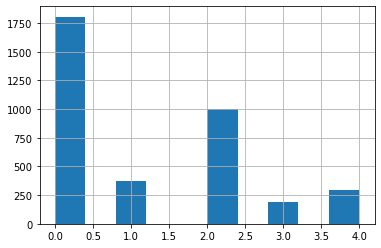

In [3]:
test_df['diagnosis'].hist()
test_df['diagnosis'].value_counts()

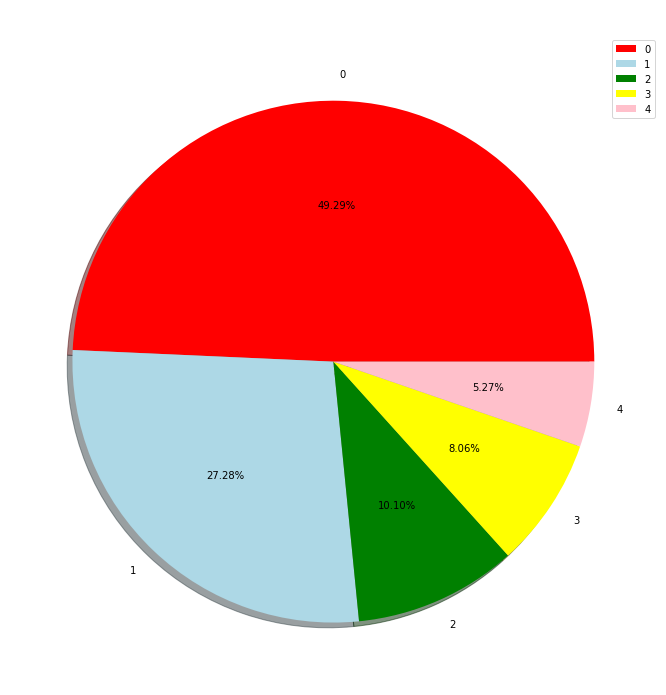

In [4]:

labels = ['0', '1', '2', '3' ,'4']
size = train_df['diagnosis'].value_counts()
colors = ['red', 'lightblue','green', 'yellow', 'pink']


plt.rcParams['figure.figsize'] = (12,12)
plt.pie(size, colors = colors,  labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('diagnosis', fontsize = 30, color='white')
plt.axis('off')
plt.legend()
plt.show()

In [5]:
!pip install opencv-python

  Using cached opencv_python-4.2.0.34-cp37-cp37m-manylinux1_x86_64.whl (28.2 MB)


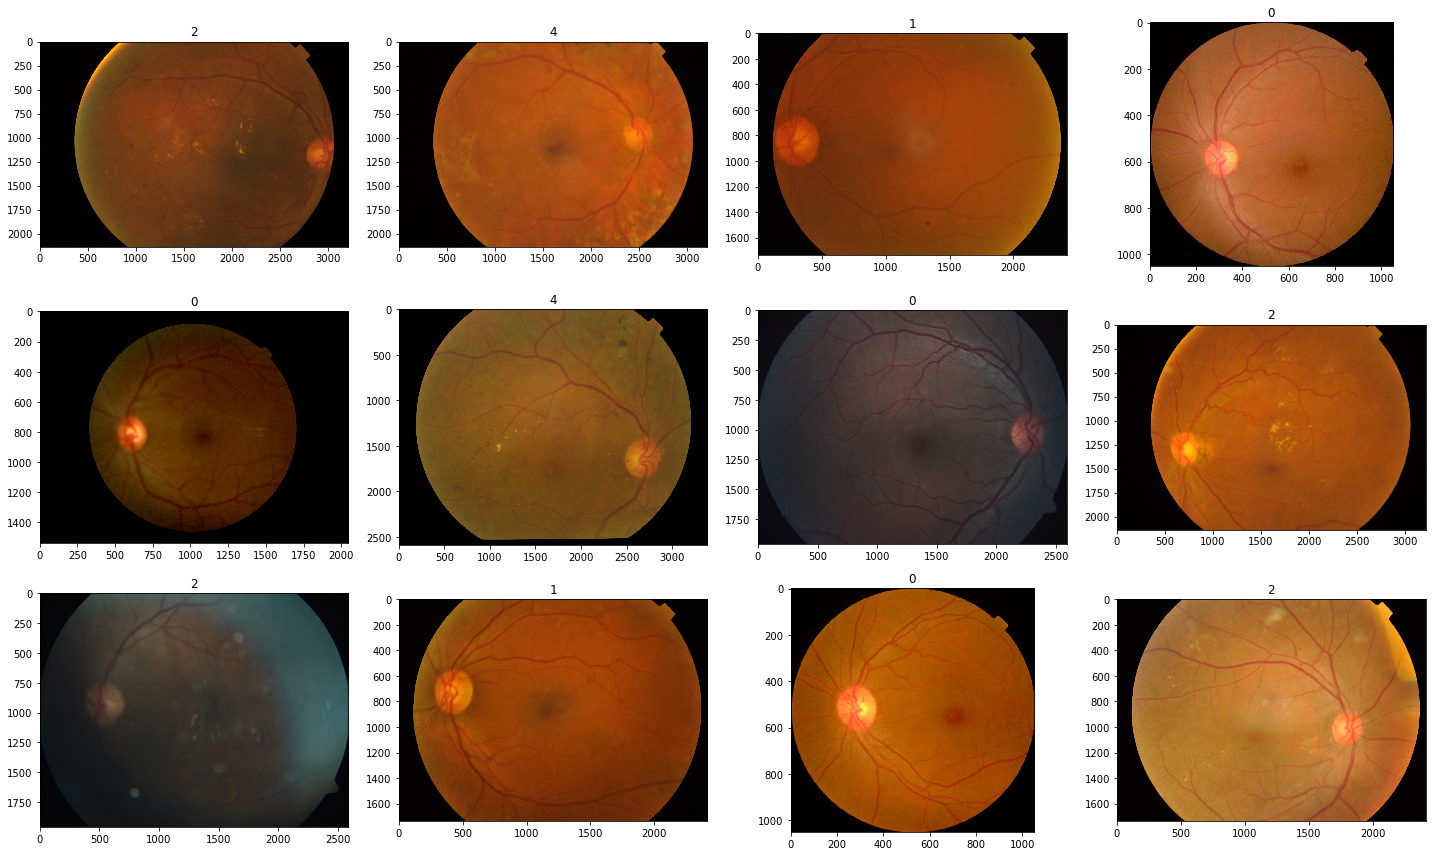

In [6]:
import cv2
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'/datasets/aptos2019-blindness-detection/train_images/{image_path}.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)


In [7]:
def get_pad_width(im, new_shape, is_rgb=True):
    pad_diff = new_shape - im.shape[0], new_shape - im.shape[1]
    t, b = math.floor(pad_diff[0]/2), math.ceil(pad_diff[0]/2)
    l, r = math.floor(pad_diff[1]/2), math.ceil(pad_diff[1]/2)
    if is_rgb:
        pad_width = ((t,b), (l,r), (0, 0))
    else:
        pad_width = ((t,b), (l,r))
    return pad_width

def preprocess_image(image_path, desired_size=224):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    
    return im

In [8]:
N = train_df.shape[0]
x_train = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(train_df['id_code'])):
    x_train[i, :, :, :] = preprocess_image(
        f'/datasets/aptos2019-blindness-detection/train_images/{image_id}.png'
    )

100%|██████████| 3662/3662 [09:28<00:00,  6.44it/s]


In [9]:
y_train = pd.get_dummies(train_df['diagnosis']).values

print(x_train.shape)
print(y_train.shape)


(3662, 224, 224, 3)
(3662, 5)


In [10]:
type(y_train)

numpy.ndarray

In [11]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from tqdm import tqdm

In [12]:
from keras.models import load_model
model = load_model('aptos2019_inc.h5')

In [ ]:
model0 =keras.applications.InceptionV3(include_top=False, weights='imagenet', input_tensor=None, input_shape=(224,224,3), pooling=None, classes=1000)
model0.summary()  

In [ ]:
def build_model():
    model = Sequential()
    model.add(model0)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(layers.Dense(5, activation='softmax'))
    
    
    optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy'])
    
    return model

In [15]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 22,065,701
Trainable params: 22,031,269
Non-trainable params: 34,432
_________________________________________________________________


In [14]:
X, X_test, y, y_test = train_test_split(
    x_train, y_train, 
    test_size=0.3, 
   stratify=y_train
)

In [17]:

history= model.fit(X,y,epochs=10
                    ,batch_size=32,validation_split=0.2)

Train on 2050 samples, validate on 513 samples
Epoch 1/10
2050/2050 [==============================] - 106s 51ms/step - loss: 0.8485 - accuracy: 0.6922 - val_loss: 1.8176 - val_accuracy: 0.6004
Epoch 2/10
2050/2050 [==============================] - 60s 29ms/step - loss: 0.5115 - accuracy: 0.8112 - val_loss: 1.2545 - val_accuracy: 0.7135
Epoch 3/10
2050/2050 [==============================] - 60s 29ms/step - loss: 0.3567 - accuracy: 0.8707 - val_loss: 0.8372 - val_accuracy: 0.7641
Epoch 4/10
2050/2050 [==============================] - 60s 29ms/step - loss: 0.2163 - accuracy: 0.9278 - val_loss: 0.9587 - val_accuracy: 0.7700
Epoch 5/10
2050/2050 [==============================] - 60s 29ms/step - loss: 0.1254 - accuracy: 0.9610 - val_loss: 1.0037 - val_accuracy: 0.7700
Epoch 6/10
2050/2050 [==============================] - 60s 29ms/step - loss: 0.1533 - accuracy: 0.9522 - val_loss: 1.0289 - val_accuracy: 0.7661
Epoch 7/10
2050/2050 [==============================] - 60s 29ms/step - loss

In [15]:
y_pred = model.predict(X_test.reshape(X_test.shape[0],224,224,3))
y_pred = np.argmax(y_pred, axis=-1)
y_true = tf.argmax(y_test, axis=1)
y_true = tf.keras.backend.eval(y_true)
y_pred

array([0, 2, 0, ..., 0, 2, 0])

In [16]:
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns
cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

array([[537,   5,   0,   0,   0],
       [ 10,  81,  20,   0,   0],
       [  3,  14, 274,   2,   7],
       [  0,   2,  15,  30,  11],
       [  0,   1,  20,   4,  63]])

In [17]:
from sklearn.metrics import classification_report
target_names = ['No DR', 'Mild', 'Moderate', 'Severe','Proliferative DR']
print(classification_report(y_true, y_pred, target_names=target_names))

                  precision    recall  f1-score   support

           No DR       0.98      0.99      0.98       542
            Mild       0.79      0.73      0.76       111
        Moderate       0.83      0.91      0.87       300
          Severe       0.83      0.52      0.64        58
Proliferative DR       0.78      0.72      0.75        88

        accuracy                           0.90      1099
       macro avg       0.84      0.77      0.80      1099
    weighted avg       0.89      0.90      0.89      1099

